In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_confusion_matrix
import pickle


In [106]:
from IPython.display import display, HTML
datasets = pd.read_csv('semantic_reasoning.csv')
datasets.columns = ['shape1','shape2', 'dim1', 'dim2', 'dim3', 'GT']
datasets = datasets.sort_values('GT')
X = datasets.iloc[:, :5].values
Y = datasets.iloc[:, -1].values
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
             datasets.to_html() +
             "</div>"))
X_Train_org  = X_Train
X_Test_org = X_Test
Y_Train_org  = Y_Train
Y_Test_org = Y_Test

print("Total datasize: " + str(len(datasets)))
print("cuboids: " + str(len(datasets[datasets["GT"]==0])))
print("cylinders: " + str(len(datasets[datasets["GT"]==1])))
print("spheres: " + str(len(datasets[datasets["GT"]==2])))


,shape1,shape2,dim1,dim2,dim3,GT
0,0.033125,0.154169,0.025898,0.104020,0.082843,0
103,0.151052,0.302868,0.037820,0.113484,0.104854,0
104,0.150092,0.266418,0.036935,0.109323,0.122743,0
105,0.223951,0.283890,0.045791,0.114955,0.119207,0
106,0.084673,0.203706,0.040286,0.124463,0.117404,0
107,0.131165,0.166358,0.060460,0.131568,0.109811,0
108,0.137285,0.167802,0.054497,0.047589,0.132183,0
109,0.121358,0.126136,0.044886,0.056938,0.060813,0
102,0.228186,0.317834,0.044680,0.105201,0.108280,0
110,0.049021,0.126852,0.034981,0.052461,0.043687,0


Total datasize: 550
cuboids: 161
cylinders: 330
spheres: 59


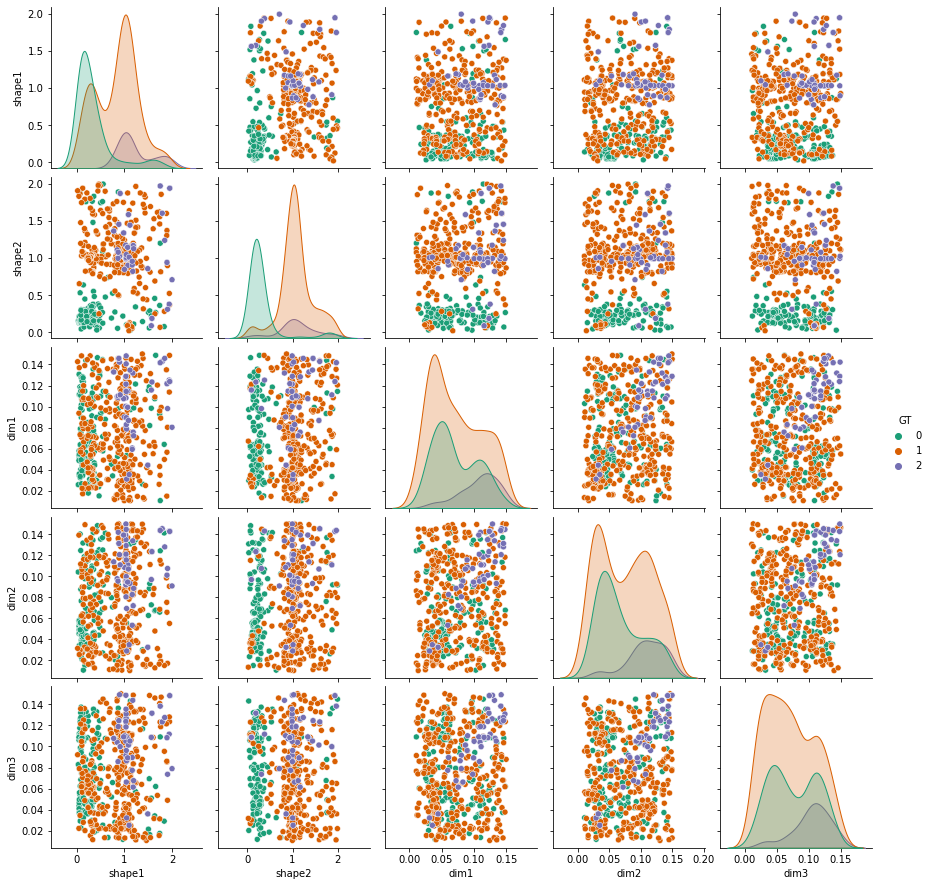

In [107]:
sns.pairplot(datasets,hue='GT',palette='Dark2')

In [108]:
# Data rescaling
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

In [139]:
# save standard scalar model
pickle.dump(sc_X, open('standard_scalar.pkl', 'wb'))


# 1. Support Vector Machine (SVM)

In [109]:
svc = SVC()
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(X_Train, Y_Train)
print(grid_search.best_estimator_) 
print(grid_search.best_params_)

SVC(C=10, gamma=0.1)
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


### 1.1 SVM: Results training data

accuracy_score_test:  0.9635922330097088


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


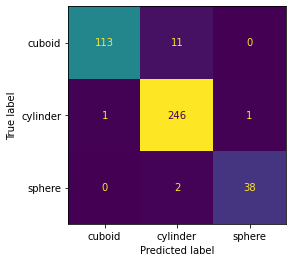

In [110]:
Y_pred_train = grid_search.predict(X_Train)
print('accuracy_score_test: ',accuracy_score(Y_Train, Y_pred_train))
# sns.heatmap(confusion_matrix(Y_Train, Y_pred_train), annot=True, fmt='d', cmap='YlGnBu')
plot_confusion_matrix(grid_search, X_Train, Y_Train, display_labels=np.array(["cuboid", "cylinder", "sphere"]), colorbar=False)  

### 1.2 SVM: Results test data (SVM)

accuracy_score_test:  0.927536231884058


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


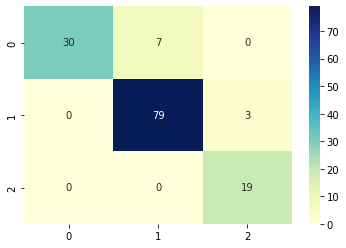

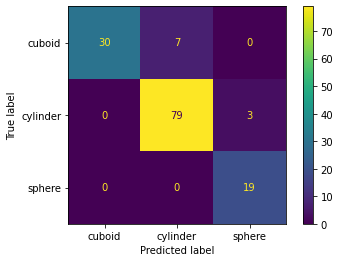

In [111]:
Y_pred_test = grid_search.predict(X_Test)
print('accuracy_score_test: ',accuracy_score(Y_Test, Y_pred_test))
sns.heatmap(confusion_matrix(Y_Test, Y_pred_test), annot=True, fmt='d', cmap='YlGnBu')
cm_svm = plot_confusion_matrix(grid_search, X_Test, Y_Test, display_labels=np.array(["cuboid", "cylinder", "sphere"])) 
cm_svm.figure_.savefig("confusion_matrix_svm.png") 

In [112]:
print(classification_report(Y_Test,Y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90        37
           1       0.92      0.96      0.94        82
           2       0.86      1.00      0.93        19

    accuracy                           0.93       138
   macro avg       0.93      0.92      0.92       138
weighted avg       0.93      0.93      0.93       138



In [ ]:
# int(grid_search.predict([[1.0179203 , 0.93124332  ,0.005187232 , 0.02107734 , 0.02758151]]))
# int(grid_search.predict([[1.30289576 , 1.05399751 , 0.02726866  ,0.03386318 , 0.12026305]]))
# int(grid_search.predict([[0.10289576 , 0.15399751 , 0.02726866  ,0.03386318 , 0.12026305]]))
int(grid_search.predict([[-0.764775060, -0.900146595,  0.851742392, -0.757077000,   0.182578923]]))

In [ ]:
print(X_Test)
print(Y_Test)

# 2. Multi-layer Perception (MLP)

In [130]:
from sklearn.neural_network import MLPClassifier
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=10000)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_Train, Y_Train) # X is train samples and y is the corresponding labels
print(clf.best_estimator_) 
print(clf.best_params_)

MLPClassifier(hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              max_iter=10000)
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


### MLP: Results training data

accuracy_score_test:  0.9975728155339806
AxesSubplot(0.125,0.125;0.62x0.755)


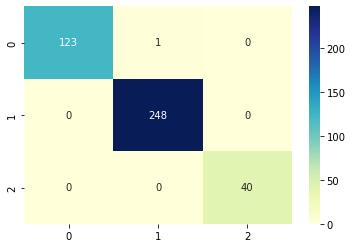

In [131]:
Y_pred_train_clf = clf.predict(X_Train)
print('accuracy_score_test: ',accuracy_score(Y_Train, Y_pred_train_clf))
print(sns.heatmap(confusion_matrix(Y_Train, Y_pred_train_clf), annot=True, fmt='d', cmap='YlGnBu'))

### MLP: Results test data

accuracy_score_test:  0.9420289855072463


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


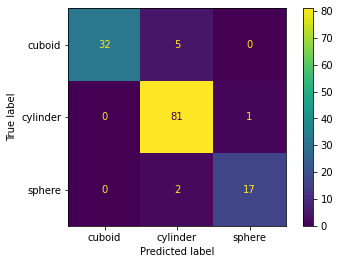

In [132]:
Y_pred_test_clf = clf.predict(X_Test)
print('accuracy_score_test: ',accuracy_score(Y_Test, Y_pred_test_clf))
# cm = sns.heatmap(confusion_matrix(Y_Test, Y_pred_test_clf), annot=True, fmt='d', cmap='YlGnBu')
cm_clf = plot_confusion_matrix(clf, X_Test, Y_Test, display_labels=np.array(["cuboid", "cylinder", "sphere"]))  


In [133]:
import matplotlib.pyplot as plt 
cm_clf.figure_.savefig("confusion_matrix_mlp.png")

In [134]:
print(classification_report(Y_Test,Y_pred_test_clf))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        37
           1       0.92      0.99      0.95        82
           2       0.94      0.89      0.92        19

    accuracy                           0.94       138
   macro avg       0.95      0.92      0.93       138
weighted avg       0.95      0.94      0.94       138



In [ ]:
# int(clf.predict([[1.0179203 , 0.93124332  ,0.1187232 , 0.02107734 , 0.02758151]]))
# int(clf.predict([[1.30289576 , 1.05399751 , 0.02726866  ,0.03386318 , 0.12026305]]))
int(grid_search.predict([[0.30289576 , 0.05399751 , 0.02726866  ,0.03386318 , 0.12026305]]))


# 3. Random Forest algorithm

In [118]:
from sklearn.ensemble import RandomForestClassifier
parameter_space = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier()
rf_grid_search = GridSearchCV(estimator=rf, param_grid=parameter_space, cv= 5)
rf_grid_search.fit(X_Train, Y_Train)
print(rf_grid_search.best_estimator_) 
print(rf_grid_search.best_params_)

RandomForestClassifier(max_depth=8, n_estimators=500)
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


accuracy_score_test:  1.0
AxesSubplot(0.125,0.125;0.62x0.755)


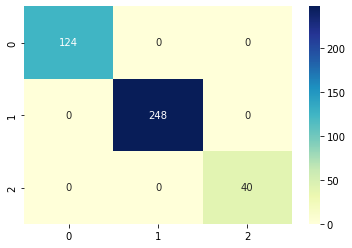

In [119]:
Y_pred_train_rf = rf_grid_search.predict(X_Train)
print('accuracy_score_test: ',accuracy_score(Y_Train, Y_pred_train_rf))
print(sns.heatmap(confusion_matrix(Y_Train, Y_pred_train_rf), annot=True, fmt='d', cmap='YlGnBu'))

accuracy_score_test:  0.927536231884058
AxesSubplot(0.125,0.125;0.62x0.755)


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


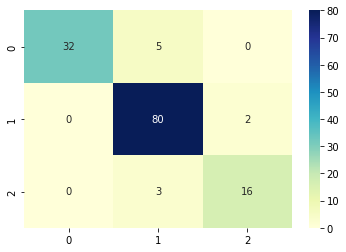

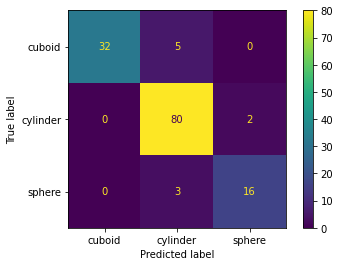

In [120]:
Y_pred_test_rf = rf_grid_search.predict(X_Test)
print('accuracy_score_test: ',accuracy_score(Y_Test, Y_pred_test_rf))
print(sns.heatmap(confusion_matrix(Y_Test, Y_pred_test_rf), annot=True, fmt='d', cmap='YlGnBu'))
cm_rf = plot_confusion_matrix(rf_grid_search, X_Test, Y_Test, display_labels=np.array(["cuboid", "cylinder", "sphere"]))  
cm_rf.figure_.savefig("confusion_matrix_rf.png") 

In [121]:
print(classification_report(Y_Test,Y_pred_test_rf))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        37
           1       0.91      0.98      0.94        82
           2       0.89      0.84      0.86        19

    accuracy                           0.93       138
   macro avg       0.93      0.89      0.91       138
weighted avg       0.93      0.93      0.93       138



In [ ]:
fpr, tpr, _ = roc_curve(Y_Test, Y_pred_test_rf, pos_label=clf.classes_[1])
print(auc(fpr, tpr))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
# int(rf_grid_search.predict([[1.0179203 , 0.93124332  ,0.005187232 , 0.02107734 , 0.02758151]]))
# int(rf_grid_search.predict([[1.30289576 , 1.05399751 , 0.02726866  ,0.03386318 , 0.12026305]]))
int(grid_search.predict([[0.30289576 , 0.05399751 , 0.02726866  ,0.03386318 , 0.12026305]]))




# 4. Heuristic approach (logic-based approach)

In [122]:
def heuristic_function(Data):
    y_pred = []

    for shape in Data:
        if 0 <= shape[0] <= 0.7 and 0 <= shape[1] <= 0.7 and (-shape[0]-shape[1]+0.7) >= 0:
            y_pred.append(0)
        elif 0 <= shape[0] <= 0.7 and 1.3 <= shape[1] <= 2 and (shape[1]-shape[0]-1.3) >= 0: 
            y_pred.append(0)
        elif (-shape[1]-shape[0]+0.7) <= 0.7 and -shape[1] + shape[0] + 1.3 > 0 and not (0.9 < shape[0] < 1.1 and 0.9 < shape[1] < 1.1 and (max(shape[2:])/min(shape[2:]))<1.3):
            y_pred.append(1)
        elif 0.9 <= shape[0] <= 1.1 and 0.9 <= shape[1] <= 1.1 and (max(shape[2:])/min(shape[2:]))<1.3:
            y_pred.append(2)
        else: 
            y_pred.append(np.nan)
            print("for shape: ", shape, " no match found!!")
    return y_pred


accuracy_score_test:  0.8398058252427184
AxesSubplot(0.125,0.125;0.62x0.755)


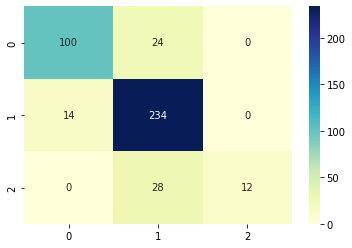

In [123]:
y_train_pred_heur = heuristic_function(X_Train_org[:,:5])
print('accuracy_score_test: ',accuracy_score(Y_Train, y_train_pred_heur))
print(sns.heatmap(confusion_matrix(Y_Train, y_train_pred_heur), annot=True, fmt='d', cmap='YlGnBu'))
cm_svm.figure_.savefig("confusion_matrix_svm.png") 

accuracy_score_test:  0.7753623188405797
AxesSubplot(0.125,0.125;0.62x0.755)


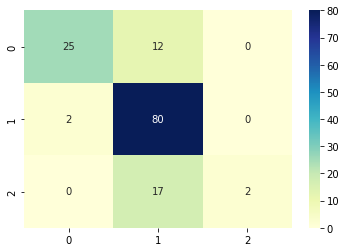

In [124]:
y_test_pred_heur = heuristic_function(X_Test_org[:,:5])
print('accuracy_score_test: ',accuracy_score(Y_Test, y_test_pred_heur))
print(sns.heatmap(confusion_matrix(Y_Test, y_test_pred_heur), annot=True, fmt='d', cmap='YlGnBu'))


In [125]:
print(classification_report(Y_Test,y_test_pred_heur))

              precision    recall  f1-score   support

           0       0.93      0.68      0.78        37
           1       0.73      0.98      0.84        82
           2       1.00      0.11      0.19        19

    accuracy                           0.78       138
   macro avg       0.89      0.59      0.60       138
weighted avg       0.82      0.78      0.73       138



In [126]:
# heuristic_function([[1.30289576 , 1.05399751 , 0.02726866  ,0.03386318 , 0.12026305]])
heuristic_function([[0.14289576 , 0.225399751 , 0.02726866  ,0.03386318 , 0.12026305]])


[0]

# SAVE ALGORITHMS!

In [137]:
test_data_stan = np.array([[1.0179203 , 0.97124332  ,0.02187232 , 0.02107734 , 0.02758151],     # sphere
[1.30289576 , 1.05399751 , 0.02726866  ,0.03386318 , 0.12026305],   # cylinder
[1.20289576 , 1.05399751 , 0.02726866  ,0.03386318 , 0.02026305],   # sphere
[1.20289576 , 0.15399751 , 0.02726866  ,0.03386318 , 0.02026305],   # cuboid
[0.3289576 , 0.15399751 , 0.02726866  ,0.03386318 , 0.12026305]])  # cuboid

test_data = sc_X.transform(test_data_stan)


print(grid_search.predict(test_data))
print(clf.predict(test_data))
print(rf_grid_search.predict(test_data))
print(heuristic_function(test_data_stan))

[1 1 1 1 0]
[2 1 2 1 0]
[1 1 1 0 0]
[1, 1, 1, 1, 0]


In [138]:
# Save data

# Random Forest
pickle.dump(rf_grid_search.best_estimator_, open('model_rf.pkl', 'wb'))

# MLP Algorithm
pickle.dump(clf.best_estimator_, open('model_mlp.pkl', 'wb'))

# SVM
pickle.dump(grid_search.best_estimator_, open('model_svm.pkl', 'wb'))




In [ ]:
# Load data

# load
# with open('model_mlp.pkl', 'rb') as f:
#     mlp_model = pickle.load(f)
result = int(mlp_model.predict([[1.0179203 , 0.93124332  ,0.005187232 , 0.02107734 , 0.02758151]]))
result
# # result = int(SVC_model.predict([[0.102137575067499,	1.02867854047452	,0.333157138503882	,0.132167898866081,	0.025691348723388]]))
# shapes = ['cuboid', 'cylinder', 'sphere']
# print(result)
# shapes[result]

